In [269]:
import yaml
import pandas as pd
import durationpy
import plotnine as p9
import numpy as np
from plotnine import *
import random
import math
import glob

p9.options.figure_size = (12, 8)
colors = ['#e69f00', '#56b4e9', '#009e73', '#cc79a7', '#000000', '#f0e442', '#0072b2', '#d55e00']

In [355]:
%%time
frac = 0.1
src = 'aws'
c = 1
workload = 'http'

dfs = []
meta = []
for dir_path in glob.glob('../'+src+'/'+workload+'/'+str(c)+'/*/*'):
    _, _, _, concurrency, profilers, run = dir_path.split('/')
    data = yaml.load(open(dir_path+'/result.yaml', 'r'), yaml.SafeLoader)
    df = pd.read_csv(dir_path+'/ops.csv', parse_dates=['start'], skiprows=lambda i: i>0 and random.random() > frac)
    df['start'] = df['start'] - data['result']['start']
    df['duration'] = df['duration'].map(pd.to_timedelta)
    df['profilers'] = profilers
    df['workload'] = workload
    df['concurrency'] = concurrency
    df['run'] = run
    dfs.append(df)
    
    meta.append({
        'workload': workload,
        'concurrency': concurrency,
        'profilers': profilers,
        'run': run,
        'result': data['result'],
        'ops': len(df)/frac,
    })

ops = pd.concat(dfs, ignore_index=True)
ops

CPU times: user 8.11 s, sys: 122 ms, total: 8.23 s
Wall time: 8.32 s


,start,duration,error,profilers,workload,concurrency,run
0,0 days 00:00:00.002550192,0 days 00:00:00.000071159,NaN,cpu,http,1,0
1,0 days 00:00:00.003030736,0 days 00:00:00.000065658,NaN,cpu,http,1,0
2,0 days 00:00:00.003096480,0 days 00:00:00.000091305,NaN,cpu,http,1,0
3,0 days 00:00:00.004383759,0 days 00:00:00.000064338,NaN,cpu,http,1,0
4,0 days 00:00:00.004656394,0 days 00:00:00.000066318,NaN,cpu,http,1,0
...,...,...,...,...,...,...,...
343512,0 days 00:00:10.000072695,0 days 00:00:00.000060354,NaN,mem,http,1,2
343513,0 days 00:00:10.000598408,0 days 00:00:00.000047036,NaN,mem,http,1,2
343514,0 days 00:00:10.001537910,0 days 00:00:00.000063470,NaN,mem,http,1,2
343515,0 days 00:00:10.001601512,0 days 00:00:00.000059461,NaN,mem,http,1,2


In [451]:
stats = []
base_durations = ops[ops['profilers'] == 'none']['duration']

def push_stat(profilers, name, base, val):
    stats.append({
        'profilers': profilers,
        'stat': name,
        'ratio': val/base - 1,
    })


for profilers in ops.profilers.unique():
    durations = ops[ops['profilers'] == profilers]['duration']

    push_stat(profilers, 'mean', base_durations.mean(), durations.mean())
    push_stat(profilers, 'p50', base_durations.quantile(0.5), durations.quantile(0.5))
    push_stat(profilers, 'p99', base_durations.quantile(0.99), durations.quantile(0.99))

stats = pd.DataFrame(stats)
stats
# baseline = p99(ops[ops['profilers'] == 'none'].duration)

# def p99(x):
#     return x.quantile(0.99)

# means = ops.groupby('profilers')['duration'].agg([np.mean, np.min, np.max, p99]).reset_index()
# means['ratio'] = ((means['p99'] / baseline) - 1)
# # means
# means.pivot(values=['profilers', 'p99'])

,profilers,stat,ratio
0,cpu,mean,-0.007267
1,cpu,p50,-0.006629
2,cpu,p99,-0.002205
3,"cpu,mem",mean,-0.004394
4,"cpu,mem",p50,-0.003417
5,"cpu,mem",p99,0.004180
6,none,mean,0.000000
7,none,p50,0.000000
8,none,p99,0.000000
9,mem,mean,0.001539


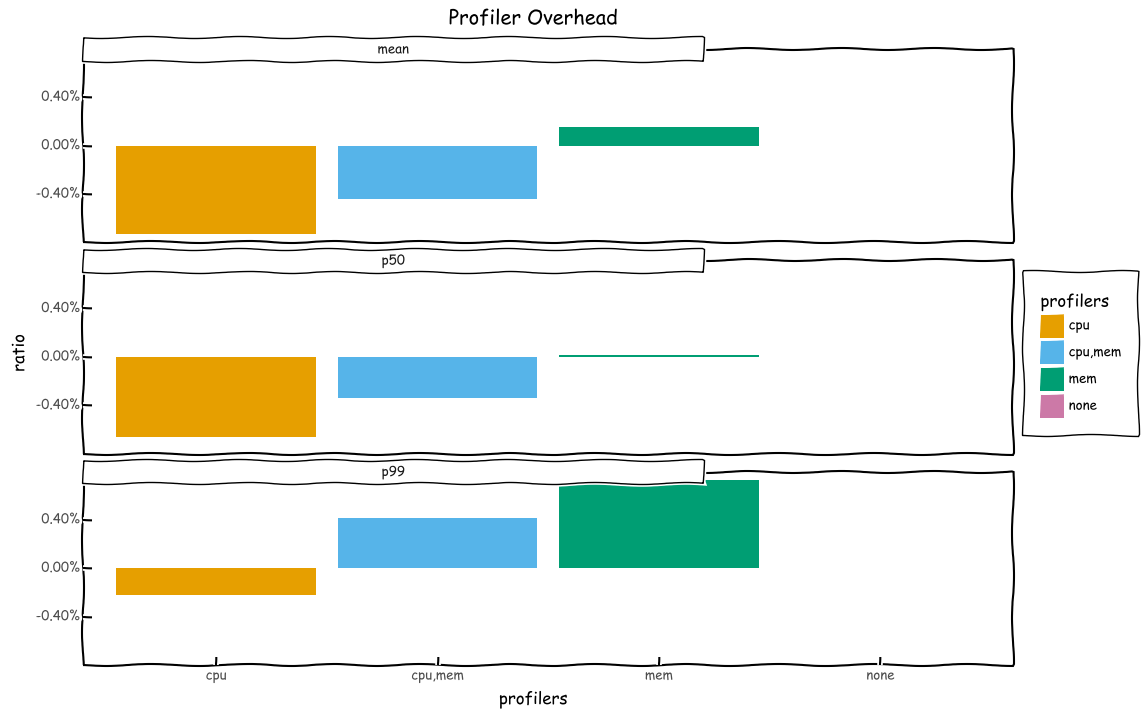

<ggplot: (348593463)>

In [453]:
(
ggplot(stats)
+ ggtitle('Profiler Overhead')
+ aes(x='profilers',y='ratio',fill='profilers')
# + ylim(-10, 10)
+ geom_bar(stat='identity')
+ facet_wrap(['stat'], ncol=1)
+ scale_fill_manual(values=colors) + theme_xkcd()
+ scale_y_continuous(labels=lambda l: ["%.2f%%" % (v * 100) for v in l])
)

In [356]:
rusage = []
for run in meta:
    before_user = pd.to_timedelta(run['result']['before_rusage']['user'])
    after_user = pd.to_timedelta(run['result']['after_rusage']['user'])
    before_sys = pd.to_timedelta(run['result']['before_rusage']['system'])
    after_sys = pd.to_timedelta(run['result']['after_rusage']['system'])
    rusage.append({
        'workload': run['workload'],
        'concurrency': run['concurrency'],
        'profilers': run['profilers'],
        'run': run['run'],
        'user': after_user-before_user,
        'sys': after_sys-before_sys,
        'ops': run['ops'],
        'user_per_op': (after_user-before_user) / run['ops'],
        'sys_per_op': (after_sys-before_sys) / run['ops'],
    })

rusage = pd.DataFrame(rusage)
rusage.head()

,workload,concurrency,profilers,run,user,sys,ops,user_per_op,sys_per_op
0,http,1,cpu,0,0 days 00:00:11.684977,0 days 00:00:09.490214,172700.0,0 days 00:00:00.000067660,0 days 00:00:00.000054952
1,http,1,cpu,1,0 days 00:00:11.280294,0 days 00:00:09.739479,173350.0,0 days 00:00:00.000065072,0 days 00:00:00.000056183
2,http,1,cpu,4,0 days 00:00:11.438552,0 days 00:00:09.637891,174880.0,0 days 00:00:00.000065408,0 days 00:00:00.000055111
3,http,1,cpu,3,0 days 00:00:11.442299,0 days 00:00:09.592013,173570.0,0 days 00:00:00.000065923,0 days 00:00:00.000055263
4,http,1,cpu,2,0 days 00:00:11.888613,0 days 00:00:09.213800,173680.0,0 days 00:00:00.000068451,0 days 00:00:00.000053050


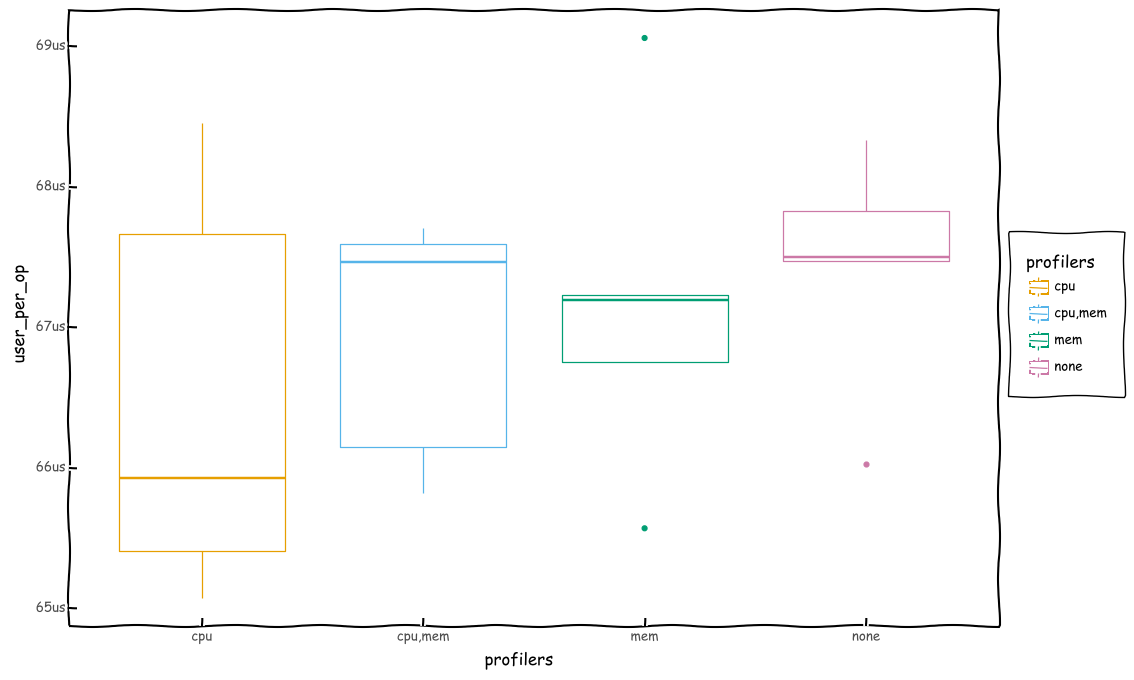

<ggplot: (341331682)>

In [358]:
(
ggplot(rusage)
+ aes(x='profilers',y='user_per_op',color='profilers')
+ geom_boxplot()
# + facet_wrap(['profilers', 'run'], ncol=5)
+ scale_color_manual(values=colors) + theme_xkcd()
)

In [347]:
desc = ops[['profilers', 'run', 'duration']].groupby(['profilers', 'run']).describe(percentiles=[0.5,0.95,0.99]).reset_index(col_level=1).droplevel(0, axis=1)
# desc
# desc = ops.groupby('profilers').describe(percentiles=[0.5,0.95,0.99]).reset_index()
# desc
# for profilers in ops.profilers.unique():
#     stats.append({
#         'profilers': profilers,
#         'p95': p95[p95['profilers'] == profilers].duration[0],
#     })
# stats = pd.DataFrame(stats)
# stats

In [363]:
qOps = ops[ops.duration < ops.duration.quantile(.99)]

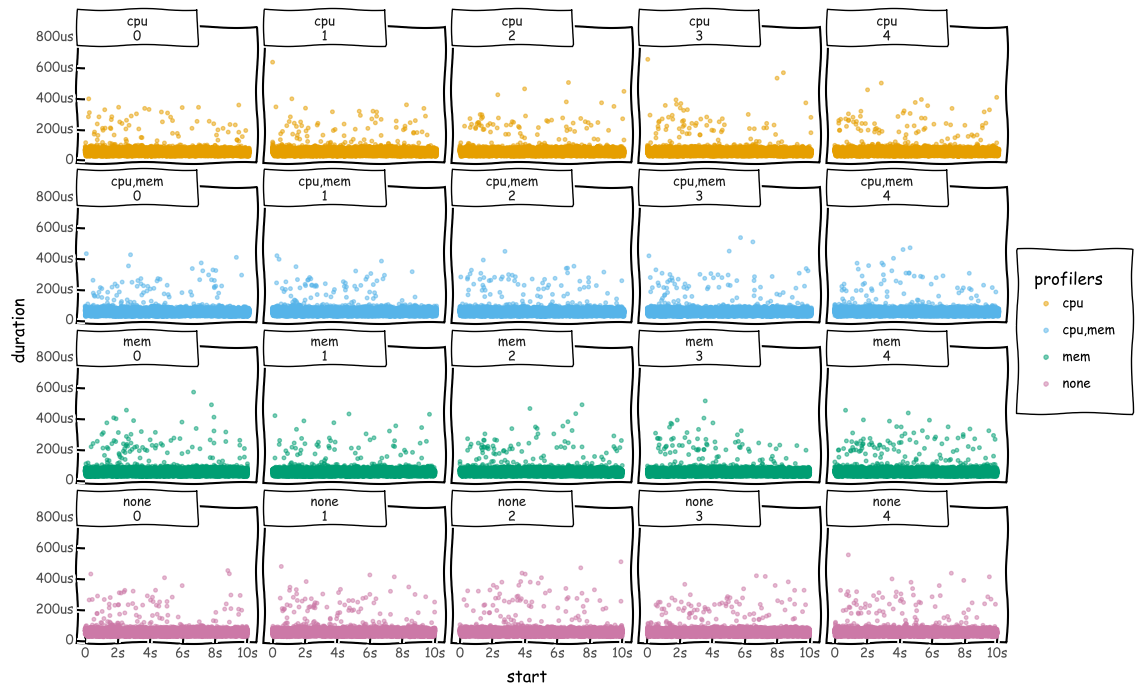

<ggplot: (348248787)>

In [365]:
(
ggplot(ops)
+ aes(x='start',y='duration',color='profilers')
+ geom_point(alpha=0.5, size=1, na_rm=True)
+ facet_wrap(['profilers', 'run'], ncol=5)
+ scale_color_manual(values=colors) + theme_xkcd()
)

In [367]:
%%time
means = pd.DataFrame(ops.groupby(['profilers', 'run']).duration.mean()).reset_index()
means = means.sort_values('duration')

CPU times: user 47.3 ms, sys: 12.6 ms, total: 59.9 ms
Wall time: 58.2 ms


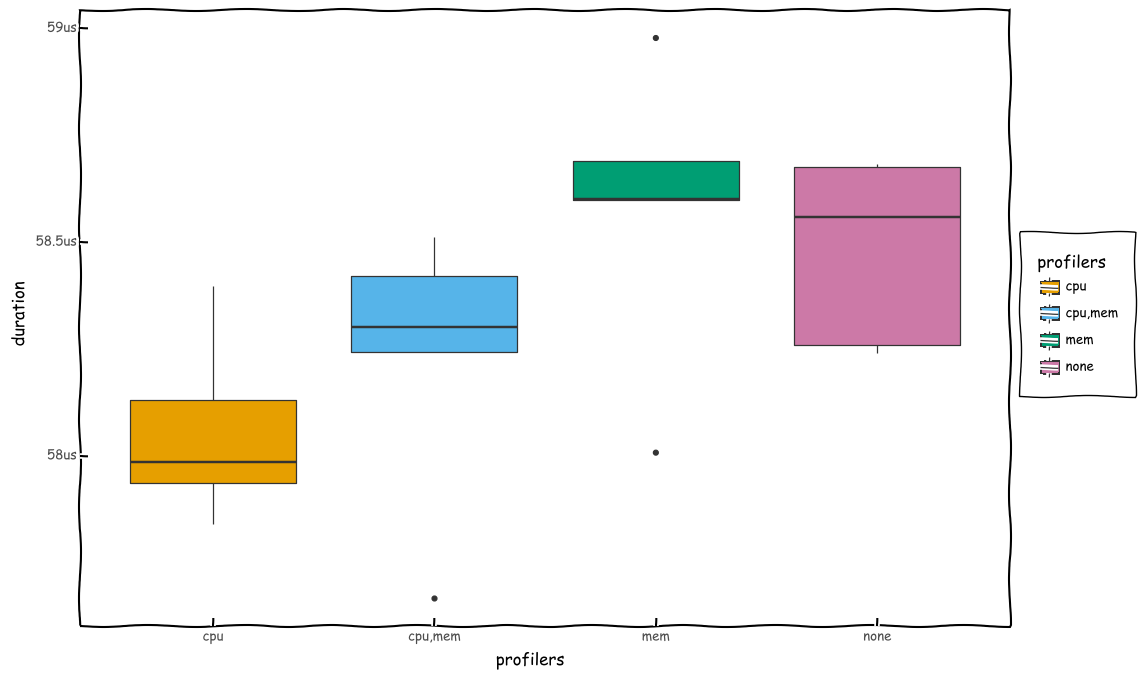

<ggplot: (341643255)>

In [368]:
(
ggplot(means)
+ aes(x='profilers',y='duration',fill='profilers')
+ geom_boxplot()
# + scale_x_discrete(limits=means['name'])
+ scale_fill_manual(values=colors) + theme_xkcd()
)

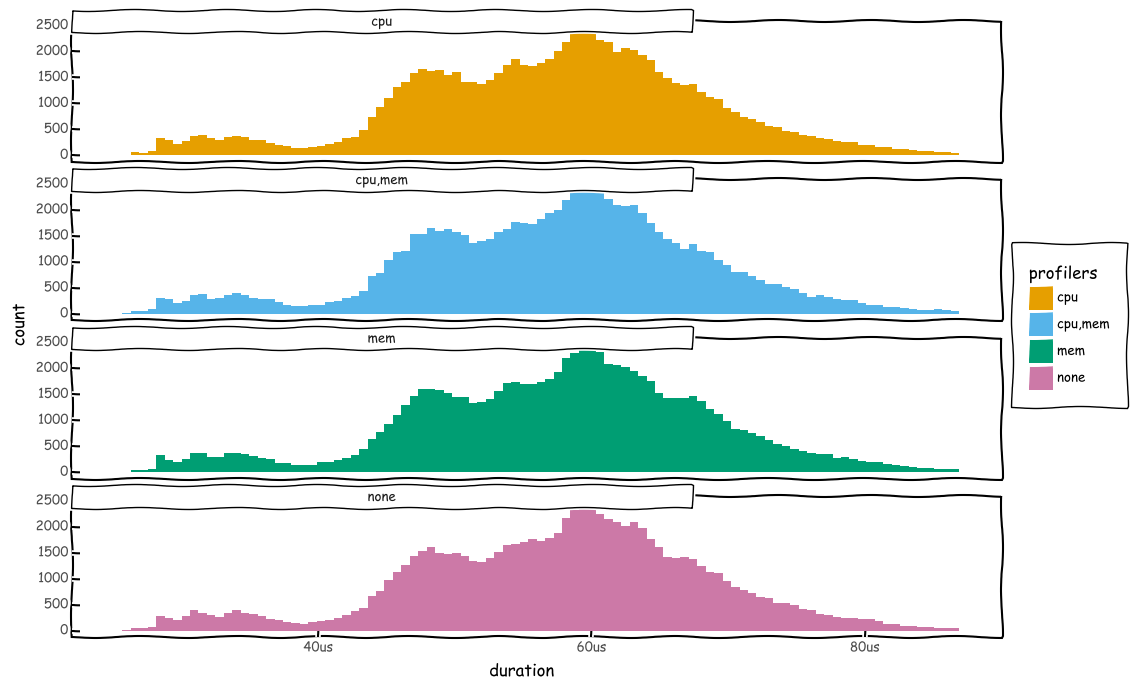

<ggplot: (344350958)>

In [366]:
(
ggplot(qOps)
+ aes(x='duration',fill='profilers')
+ geom_histogram(bins=100,position='identity')
+ facet_wrap('profilers',scales='fixed',ncol=1)
+ scale_fill_manual(values=colors) + theme_xkcd()
)

In [347]:
%%time
means = []
for name in ops.name.unique():
    durations = ops[ops['name']==name].duration
    for i in range(0, 30000):
        means.append({
            'name': name,
            'mean_duration': durations.sample(frac=1, replace=True).mean()
        })

means = pd.DataFrame(means)

CPU times: user 23.2 s, sys: 4.16 s, total: 27.4 s
Wall time: 27.4 s


In [281]:
%%time
means = []
for profilers in ops.profilers.unique():
    durations = ops[ops['profilers']==profilers].duration.values
    for i in range(0, 10000):
        means.append([profilers, np.mean(np.random.choice(durations, replace=True, size=len(durations)))])
#         means.append([profilers, np.random.choice(durations, replace=True, size=len(durations)).mean()])

means = pd.DataFrame(means, columns=['profilers', 'duration'])

CPU times: user 6.72 s, sys: 21.4 ms, total: 6.74 s
Wall time: 6.75 s


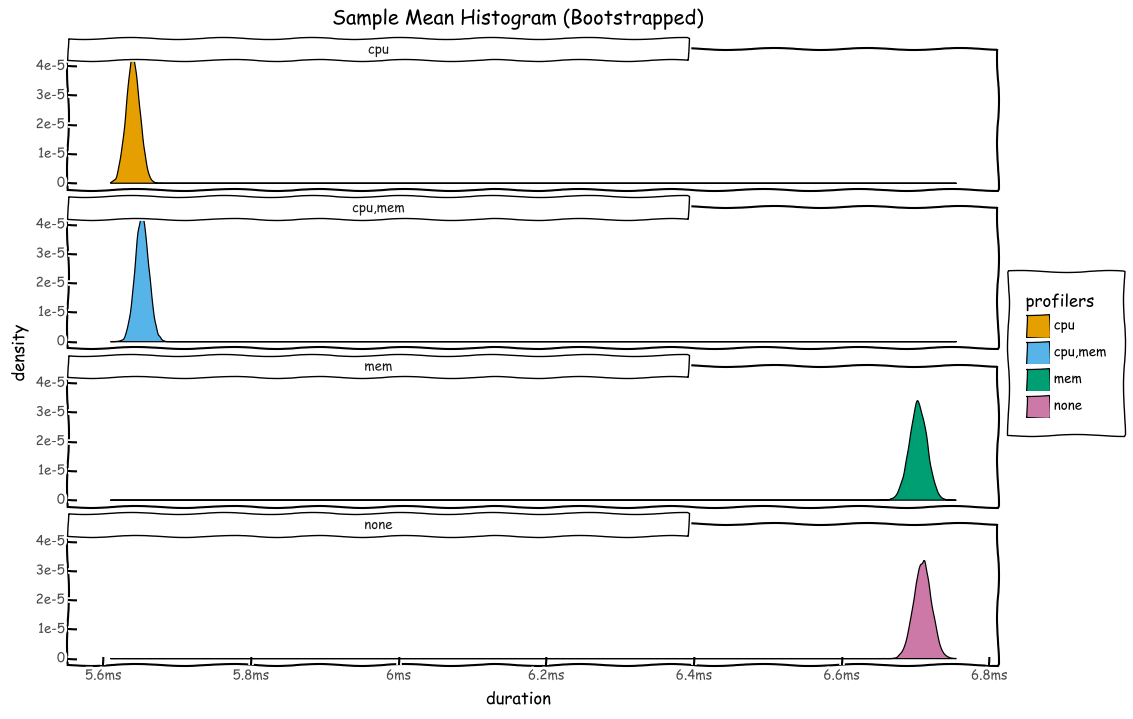

<ggplot: (341363173)>

In [282]:
(
ggplot(means)
+ ggtitle("Sample Mean Histogram (Bootstrapped)")
+ aes(x='duration',fill='profilers')
# + geom_histogram(bins=99,position='identity',alpha=1) # TODO: dynamic alpha if needed
+ geom_density()
+ facet_wrap('profilers', ncol=1)
# + geom_vline(xintercept=raw_means)
+ scale_fill_manual(values=colors) + theme_xkcd()
)